In [1]:
import numpy as np
import pickle
import csv
import torch
from torch.linalg import inv, eig, pinv
from matplotlib import pyplot as plt
from tools import whiten, adap_whitening, adap_whitening_2
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from datetime import datetime
import sklearn
import pickle
from scipy.ndimage import gaussian_filter1d
from tools import load, split, estimate_derivative, plot_two_intervals
from cycler import cycler
from matplotlib.colors import ListedColormap

In [2]:
def find_blocks(labels, max_len=20, ignore=0):
    """
    Split a 1D array of integer labels into contiguous blocks.
    - Blocks with label == `ignore` (default 0) are skipped.
    - Long runs are split into chunks of at most `max_len`.
    Returns: list of (start_idx, end_idx, label) with end_idx exclusive.
    """
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0:
        return []

    blocks = []
    start = 0
    prev = labels[0]

    # walk + flush on change (and once at the end)
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                # chunk the run to respect max_len
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))
                    s = e
            start = i
            prev = cur

    return blocks

In [3]:
rng = np.random.default_rng(42)  # for reproducibility

In [4]:
n_hd = 10000
n_out = 3
k = 25
n_train = 450

filename = '1_600_20'

sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=sensor_data)
sensor_data = np.hstack((sensor_data, d_sensor_data))

# baseline = np.mean(sensor_data[:300], axis=0)  # Add baseline substraction
# sensor_data = (sensor_data - baseline)

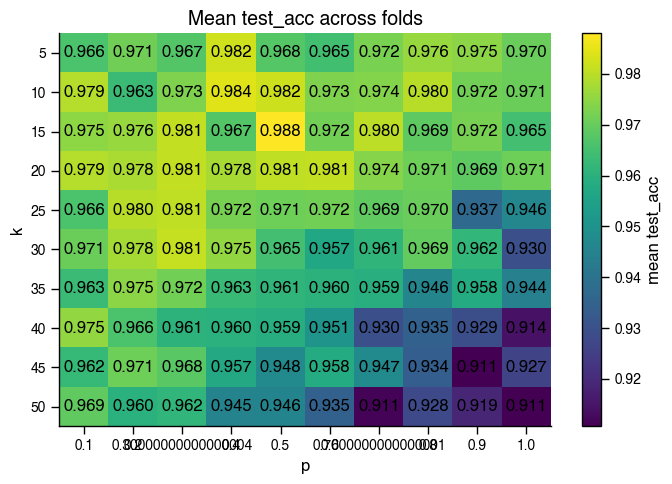

In [5]:
# --- load ---
with open("data/gridsearch_stochastic.pkl", "rb") as f:
    d = pickle.load(f)

k  = np.asarray(d["params"]["k"])
p  = np.asarray(d["params"]["p"])
ta = np.asarray(d["results"]["test_acc"], dtype=float)

# --- group by (k, p) and compute means across folds (no pandas) ---
# sort by (k, p)
idx = np.lexsort((p, k))       # primary k, then p
ks, ps, tas = k[idx], p[idx], ta[idx]

# find group starts where (k, p) changes
chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
starts = np.r_[0, np.flatnonzero(chg) + 1]

# sums and counts per group → means
sums = np.add.reduceat(tas, starts)
counts = np.diff(np.r_[starts, tas.size])
means = sums / counts

gk = ks[starts]   # k per group
gp = ps[starts]   # p per group

# --- put into a 2D grid (rows=k, cols=p) ---
ku = np.unique(k)
pu = np.unique(p)
grid = np.full((ku.size, pu.size), np.nan)

ki = np.searchsorted(ku, gk)
pi = np.searchsorted(pu, gp)
grid[ki, pi] = means

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(grid, aspect="auto")  # default colormap
ax.set_xticks(np.arange(pu.size)); ax.set_xticklabels(pu)
ax.set_yticks(np.arange(ku.size)); ax.set_yticklabels(ku)
ax.set_xlabel("p")
ax.set_ylabel("k")
ax.set_title("Mean test_acc across folds")

# annotate cells
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if np.isfinite(grid[i, j]):
            ax.text(j, i, f"{grid[i, j]:.3f}", ha="center", va="center")

fig.colorbar(im, ax=ax, label="mean test_acc")
plt.tight_layout()
plt.show()


In [6]:
k       = np.asarray(d["params"]["k"])
p       = np.asarray(d["params"]["p"])
n_fold  = np.asarray(d["params"]["n_fold"])
testacc = np.asarray(d["results"]["test_acc"], dtype=float)

# --- group by (k, p) and compute mean across folds ---
idx = np.lexsort((p, k))           # sort by k, then p
ks, ps, tas = k[idx], p[idx], testacc[idx]

chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
starts = np.r_[0, np.flatnonzero(chg) + 1]

sums   = np.add.reduceat(tas, starts)
counts = np.diff(np.r_[starts, tas.size])
means  = sums / counts

gk = ks[starts]
gp = ps[starts]

# --- pick best group by highest mean ---
best_group = int(np.nanargmax(means))
best_k = gk[best_group]
best_p = gp[best_group]

# all folds at those params
mask = (k == best_k) & (p == best_p)
best_vals = testacc[mask]
best_folds = n_fold[mask]

# best single-fold at those params
best_single_idx = int(np.nanargmax(best_vals))
best_n_fold = best_folds[best_single_idx]

# --- print in requested style (adapted: p instead of N_pot, no t_delay available) ---
print(
    f"Best params → k={best_k}, p={best_p}\n"
    f"Highest mean test accuracy: {np.nanmean(best_vals):.4f} ± {np.nanstd(best_vals):.4f} (n={best_vals.size})\n"
    f"Highest single-fold test accuracy at those params: {np.nanmax(best_vals):.4f}, n_fold={best_n_fold}"
)

Best params → k=15, p=0.5
Highest mean test accuracy: 0.9880 ± 0.0111 (n=20)
Highest single-fold test accuracy at those params: 1.0000, n_fold=0


In [7]:
# --- load ---
with open("data/gridsearch_pseudoderivative.pkl", "rb") as f:
    d = pickle.load(f)

k  = np.asarray(d["params"]["k"])
p  = np.asarray(d["params"]["p"])
ta = np.asarray(d["results"]["test_acc"], dtype=float)

# --- group by (k, p) and compute means across folds (no pandas) ---
# sort by (k, p)
idx = np.lexsort((p, k))       # primary k, then p
ks, ps, tas = k[idx], p[idx], ta[idx]

# find group starts where (k, p) changes
chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
starts = np.r_[0, np.flatnonzero(chg) + 1]

# sums and counts per group → means
sums = np.add.reduceat(tas, starts)
counts = np.diff(np.r_[starts, tas.size])
means = sums / counts

gk = ks[starts]   # k per group
gp = ps[starts]   # p per group

# --- put into a 2D grid (rows=k, cols=p) ---
ku = np.unique(k)
pu = np.unique(p)
grid = np.full((ku.size, pu.size), np.nan)

ki = np.searchsorted(ku, gk)
pi = np.searchsorted(pu, gp)
grid[ki, pi] = means

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(grid, aspect="auto")  # default colormap
ax.set_xticks(np.arange(pu.size)); ax.set_xticklabels(pu)
ax.set_yticks(np.arange(ku.size)); ax.set_yticklabels(ku)
ax.set_xlabel("p")
ax.set_ylabel("k")
ax.set_title("Mean test_acc across folds")

# annotate cells
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if np.isfinite(grid[i, j]):
            ax.text(j, i, f"{grid[i, j]:.3f}", ha="center", va="center")

fig.colorbar(im, ax=ax, label="mean test_acc")
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/gridsearch_pseudoderivative.pkl'

In [ ]:
k       = np.asarray(d["params"]["k"])
p       = np.asarray(d["params"]["p"])
n_fold  = np.asarray(d["params"]["n_fold"])
testacc = np.asarray(d["results"]["test_acc"], dtype=float)

# --- group by (k, p) and compute mean across folds ---
idx = np.lexsort((p, k))           # sort by k, then p
ks, ps, tas = k[idx], p[idx], testacc[idx]

chg = (ks[1:] != ks[:-1]) | (ps[1:] != ps[:-1])
starts = np.r_[0, np.flatnonzero(chg) + 1]

sums   = np.add.reduceat(tas, starts)
counts = np.diff(np.r_[starts, tas.size])
means  = sums / counts

gk = ks[starts]
gp = ps[starts]

# --- pick best group by highest mean ---
best_group = int(np.nanargmax(means))
best_k = gk[best_group]
best_p = gp[best_group]

# all folds at those params
mask = (k == best_k) & (p == best_p)
best_vals = testacc[mask]
best_folds = n_fold[mask]

# best single-fold at those params
best_single_idx = int(np.nanargmax(best_vals))
best_n_fold = best_folds[best_single_idx]

# --- print in requested style (adapted: p instead of N_pot, no t_delay available) ---
print(
    f"Best params → k={best_k}, p={best_p}\n"
    f"Highest mean test accuracy: {np.nanmean(best_vals):.4f} ± {np.nanstd(best_vals):.4f} (n={best_vals.size})\n"
    f"Highest single-fold test accuracy at those params: {np.nanmax(best_vals):.4f}, n_fold={best_n_fold}"
)

In [8]:
n_hd = 10000
n_out = 3
k = 15
p = 0.2
n_train = 450


x_dense = sensor_data
n_dense = x_dense.shape[1]

labels = np.zeros_like(times_sec)
for i, t in enumerate(sequence_sec[:n_train]):
    try:
        flag = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i])
    labels[flag] = int(sequence[i][1])

idx_last_flag = np.where(labels != 0)[0][-1]

W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
x_hd = x_dense @ W_hd.T
z_hd = np.where(np.argsort(x_hd)<k, 1., 0)
W_out = np.zeros((n_out, n_hd))
W = np.zeros((n_out, n_hd))

z_out_train = np.zeros((z_hd.shape[0],  n_out))
for i, row in enumerate(z_hd[:idx_last_flag]):
    if labels[i] != 0:
        active_idx = np.flatnonzero(row)
        to_flip = active_idx[rng.random(active_idx.size) < p]     # Bernoulli(p) per active index# indices where z_hd==1
        W_out[int(labels[i])-1, to_flip] = 1./k


    out = row @ W_out.T
    z_out_train[i] = out

z_out_acc = np.zeros((z_hd.shape[0],  n_out))
for i, row in enumerate(z_hd):
    out = row @ W_out.T
    z_out_acc[i] = out

z_wta = np.where(np.argsort(z_out_acc, axis=1)<1, 1., 0)

z_pred = np.zeros_like(sequence_sec)
z_true = np.zeros_like(sequence_sec)
for i, t in enumerate(sequence_sec):
    try:
        flag = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i])
    z_pred[i] = np.argsort(np.sum(z_out_acc[flag], axis=0))[-1] + 1
    z_true[i] = sequence[i][1]

train_acc = sklearn.metrics.accuracy_score(z_true[:n_train], z_pred[:n_train])
test_acc = sklearn.metrics.accuracy_score(z_true[n_train:], z_pred[n_train:])

print(f'k: {k}, p: {p}')
print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

z_out = np.empty((z_hd.shape[0],  n_out))
z_out[:idx_last_flag] = z_out_train[:idx_last_flag]
z_out[idx_last_flag:] = z_out_acc[idx_last_flag:]

k: 15, p: 0.2
Train accuracy: 1.0000, Test accuracy: 0.9933


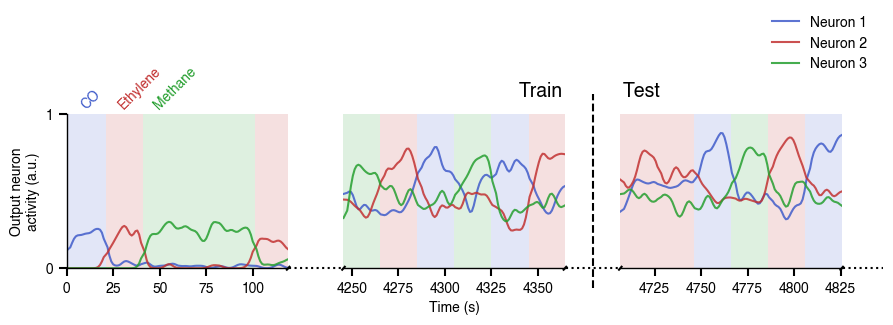

In [9]:
# ----- config -----
top_intervals_idx = [(0, 6), (212, 218)]   # left & middle (sequence-index windows)
j0, j1 = 235, 241                            # right "Test" (sequence-index)
max_len = 20
sigma = 2.
savepath = 'figs/hd_out'

# connector + slash styling
connector_color   = 'black'
connector_lw      = 1.5
connector_ls      = ':'      # dotted
slash_color       = 'black'
slash_lw          = 1.5
slash_len_fig     = 0.015
slash_angle_deg   = 80
slash_inset       = 0.003
# right slashes are NOT mirrored

# ----- style -----
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 14,
    "legend.fontsize": 10
})
cm = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'], name='custom')

# ----- per-sample block labels over full recording -----
colour = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour[mask] = int(sequence[i][1])

# ----- helpers -----
def seq_idx_window_to_sample_idx(a_idx, b_idx):
    a_idx = int(np.clip(a_idx, 0, len(sequence_sec) - 1))
    b_idx = int(np.clip(b_idx, 0, len(sequence_sec) - 1))
    t0_sec = sequence_sec[a_idx]
    t1_sec = sequence_sec[b_idx]
    t0 = int(np.abs(times_sec - t0_sec).argmin())
    t1 = int(np.abs(times_sec - t1_sec).argmin())
    if t1 <= t0:
        t1 = min(t0 + 1, len(times_sec))
    return t0, t1

def find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0: return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s, e) end-exclusive
                    s = e
            start, prev = i, cur
    return blocks

# Use midpoints between samples as span edges -> no visual gaps
def block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s-1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e-1] + x[e])
    return L, R

# ----- figure (1x3) -----
fig, ax = plt.subplots(1, 3, figsize=(10, 2),
                       sharey=False,
                       gridspec_kw={'wspace': 0.25})
ax_l, ax_m, ax_r = ax[0], ax[1], ax[2]

# windows (sample indices)
t0_a, t1_a       = seq_idx_window_to_sample_idx(*top_intervals_idx[0])  # left
t0_b, t1_b       = seq_idx_window_to_sample_idx(*top_intervals_idx[1])  # middle
t0_test, t1_test = seq_idx_window_to_sample_idx(j0, j1)                 # right

# GLOBAL origin: first time from LEFT window
x0_ref = times_sec[t0_a]

def plot_interval_time_x(ah, t0, t1, title=None, pos=None, hide_y=False):
    # time axis shifted by the SAME origin (x0_ref)
    x_raw = times_sec[t0:t1]
    x = x_raw - x0_ref

    labels_local = colour[t0:t1]
    blocks = find_blocks(labels_local, max_len=max_len)

    # traces vs time
    for i in range(z_out.shape[1]):
        smoothed = gaussian_filter1d(z_out[t0:t1, i], sigma=sigma)
        ah.plot(x, smoothed, label=f'Neuron {i+1}', color=cm(i % cm.N), lw=1.5, alpha=0.85)

    # shaded blocks (midpoint edges => no gaps)
    for s, e, lab in blocks:
        if lab == 0:
            continue
        L, R = block_edges_from_indices(x, s, e)
        if R > L:
            ah.axvspan(L, R, facecolor=cm((lab-1) % cm.N), alpha=0.15, linewidth=0)

    # axes styling
    for side in ['top','right','left','bottom']:
        ah.spines[side].set_visible(side in ['left','bottom'])
    ah.tick_params(axis='both', which='both', width=1.5)
    ah.set_xlim(x[0], x[-1])
    ah.set_ylim(0., 1.)

    if not hide_y:
        ah.set_yticks([0, 1])
    else:
        ah.set_yticks([])
        ah.set_ylabel("")
        ah.spines['left'].set_visible(False)

    if title:
        if pos=="left":
            ah.text(0.01, 1.15, title, transform=ah.transAxes,
                    va="center", ha="left", fontsize=14)
        elif pos=="right":
            ah.text(0.99, 1.15, title, transform=ah.transAxes,
                    va="center", ha="right", fontsize=14)

# ----- plot panels (single row) -----
plot_interval_time_x(ax_l, t0_a,   t1_a,   title=None,   hide_y=False)  # left
plot_interval_time_x(ax_m, t0_b,   t1_b,   title="Train", pos='right',  hide_y=True)  # middle (hide y)
plot_interval_time_x(ax_r, t0_test,t1_test,title="Test", pos='left', hide_y=True) # right

# ----- Gas labels -----
# Optional name mapping; otherwise we'll show "Gas {lab}"
gas_names = {
    1: "CO",
    2: "Ethylene",
    3: "Methane",
}

def _label_for(lab):
    return gas_names.get(lab, f"Gas {lab}")

def add_gas_labels(ah, t0, t1, offset_frac=0.05, angle_deg=45):
    # same x / blocks construction as in plot_interval_time_x
    x_raw = times_sec[t0:t1]
    x = x_raw - x0_ref
    labels_local = colour[t0:t1]
    blocks = find_blocks(labels_local, max_len=max_len)

    y0, y1 = ah.get_ylim()
    y_off = 0.02 * (y1 - y0)  # vertical offset above axis top

    prev_lab = None
    for s, e, lab in blocks:
        if lab == 0 or lab == prev_lab:
            prev_lab = lab
            continue
        prev_lab = lab

        L, R = block_edges_from_indices(x, s, e)
        if R <= L:
            continue

        # shift a bit to the right of center
        x_mid = 0.5 * (L + R)
        dx = offset_frac * (R - L)  # fraction of block width
        x_lbl = x_mid + dx

        ah.text(
            x_lbl, y1 + y_off, _label_for(int(lab)),
            color=cm((int(lab) - 1) % cm.N),
            ha="left", va="bottom", fontsize=10,
            rotation=angle_deg, rotation_mode="anchor",
            transform=ah.transData, clip_on=False
        )

# Apply to the three panels (left / middle / right)
t0_labels, t1_labels       = seq_idx_window_to_sample_idx(0,3)
add_gas_labels(ax_l, t0_labels, t1_labels)
# add_gas_labels(ax_m, t0_b, t1_b)
# add_gas_labels(ax_r, t0_test, t1_test)

# labels
ax_l.set_ylabel("Output neuron\nactivity (a.u.)")
ax_m.set_xlabel("Time (s)")

# legend above the right subplot
handles, labels = ax_l.get_legend_handles_labels()
ax_r.legend(handles, labels, frameon=False, loc="lower center",
            bbox_to_anchor=(0.9, 1.2), ncol=1)  # adjust ncol as you like

# ----- black dotted connectors + slashes (centered on axis; equal above/below) -----
from matplotlib.lines import Line2D

# helper: bottom-spine anchor at x∈[0,1] in *axes* coords → figure coords
def bottom_anchor_in_fig(ax, x_in_axes):
    pt_disp = ax.transAxes.transform((x_in_axes, 0.0))            # axes → display
    return fig.transFigure.inverted().transform(pt_disp)          # display → figure

# exact anchors at spine ends
pL_right = bottom_anchor_in_fig(ax_l, 1.0)
pM_left  = bottom_anchor_in_fig(ax_m, 0.0)
pM_right = bottom_anchor_in_fig(ax_m, 1.0)
pR_left  = bottom_anchor_in_fig(ax_r, 0.0)
pR_right = bottom_anchor_in_fig(ax_r, 1.0)

# geometry (identical everywhere)
theta  = np.deg2rad(slash_angle_deg)
dx_fig = slash_len_fig * np.cos(theta)  # total horizontal span of the slash
dy_fig = slash_len_fig * np.sin(theta)  # total vertical span of the slash
stub   = 0.04                           # dotted continuation length (figure coords)

def draw_centered_slash(anchor_xy):
    """Draw a slash centered on the anchor, spanning equally above/below the axis."""
    xA, yA = anchor_xy
    fig.add_artist(Line2D([xA - dx_fig/2, xA + dx_fig/2],
                          [yA - dy_fig/2, yA + dy_fig/2],
                          transform=fig.transFigure, lw=slash_lw,
                          color=slash_color, clip_on=False))

def draw_gap(p_left, p_right):
    """Two centered slashes at both anchors + dotted connector between their endpoints."""
    xL, yL = p_left
    xR, yR = p_right
    # slashes (centered, same orientation)
    draw_centered_slash((xL, yL))
    draw_centered_slash((xR, yR))
    # dotted connector from right end of left slash to left end of right slash (baseline = left y)
    fig.add_artist(Line2D([xL + dx_fig/2, xR - dx_fig/2], [yL, yL],
                          transform=fig.transFigure, linestyle=connector_ls,
                          lw=connector_lw, color=connector_color, clip_on=False))

# Left ↔ Middle
draw_gap(pL_right, pM_left)

# Middle ↔ Right
draw_gap(pM_right, pR_left)

# Right-edge: centered slash at the exact right end + dotted continuation
xE, yE = pR_right
draw_centered_slash((xE, yE))
fig.add_artist(Line2D([xE + dx_fig/2, xE + dx_fig/2 + stub], [yE, yE],
                      transform=fig.transFigure, linestyle=connector_ls,
                      lw=connector_lw, color=connector_color, clip_on=False))

# helper: arbitrary axes point (x,y) -> figure coords
def axes_to_fig(ax, xy):
    return fig.transFigure.inverted().transform(ax.transAxes.transform(xy))

# top/bottom anchors for middle & right axes
pM_bottom = axes_to_fig(ax_m, (0.0, 0.0))
pM_top    = axes_to_fig(ax_m, (0.0, 1.0))
pR_bottom = axes_to_fig(ax_r, (0.0, 0.0))
pR_top    = axes_to_fig(ax_r, (0.0, 1.0))

# x coordinate halfway between the two subplots (use left edge of right and right edge of middle)
x_mid = 0.5 * (axes_to_fig(ax_m, (1.0, 0.0))[0] + axes_to_fig(ax_r, (0.0, 0.0))[0])
# x_mid = axes_to_fig(ax_m, (1.0, 0.0))[0]


# vertical extent covering the axes height (they share the same top/bottom)
y_bot = min(pM_bottom[1], pR_bottom[1])
y_top = max(pM_top[1],    pR_top[1])

# draw dotted vertical separator
fig.add_artist(Line2D([x_mid, x_mid], [y_bot-0.1, y_top+0.1],
                      transform=fig.transFigure, linestyle='--',
                      lw=connector_lw, color=connector_color, clip_on=False))


plt.savefig(f'{savepath}.pdf', bbox_inches='tight')
plt.savefig(f'{savepath}.png', dpi=200, bbox_inches='tight')

plt.show()


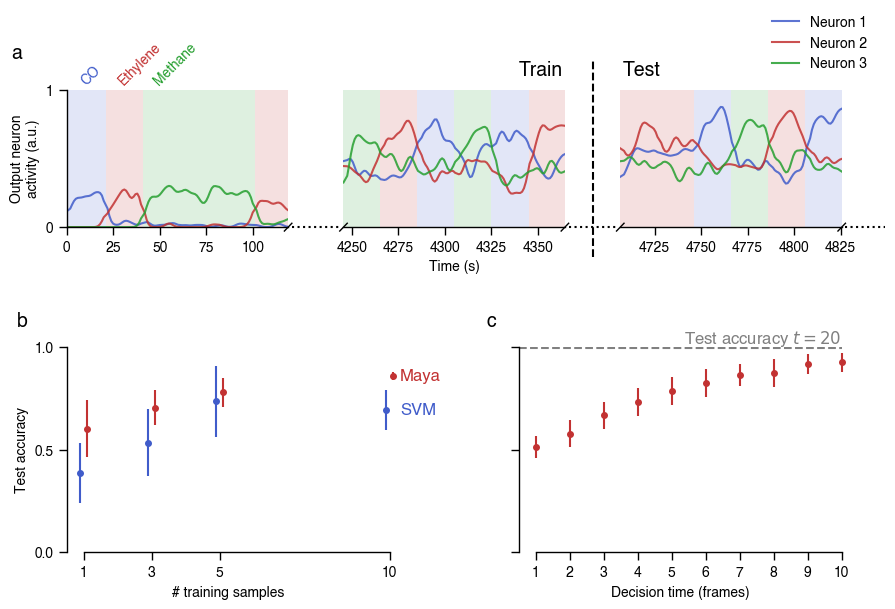

In [10]:
# ===== Combined 2x2 figure with nested GridSpec =====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# --- your existing config for the TOP row plot (unchanged) ---
top_intervals_idx = [(0, 6), (212, 218)]   # left & middle (sequence-index windows)
j0, j1 = 235, 241                           # right "Test" (sequence-index)
max_len = 20
sigma = 2.
savepath = 'figs/hd_out'  # will still save individual top-row figure products if you keep those lines
connector_color   = 'black'
connector_lw      = 1.5
connector_ls      = ':'      # dotted
slash_color       = 'black'
slash_lw          = 1.
slash_len_fig     = 0.015
slash_angle_deg   = 60
slash_inset       = 0.003

plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 14,
    "legend.fontsize": 10
})

# ----- per-sample block labels over full recording (unchanged) -----
colour = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour[mask] = int(sequence[i][1])

# ----- helpers (unchanged) -----
def seq_idx_window_to_sample_idx(a_idx, b_idx):
    a_idx = int(np.clip(a_idx, 0, len(sequence_sec) - 1))
    b_idx = int(np.clip(b_idx, 0, len(sequence_sec) - 1))
    t0_sec = sequence_sec[a_idx]
    t1_sec = sequence_sec[b_idx]
    t0 = int(np.abs(times_sec - t0_sec).argmin())
    t1 = int(np.abs(times_sec - t1_sec).argmin())
    if t1 <= t0:
        t1 = min(t0 + 1, len(times_sec))
    return t0, t1

def find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0: return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s, e) end-exclusive
                    s = e
            start, prev = i, cur
    return blocks

def block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s-1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e-1] + x[e])
    return L, R

# --- Build outer 2x2 figure (unchanged) ---
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1.0, 1.5], width_ratios=[1.0, 1.0], hspace=0.7, wspace=0.4)

# Top row (unchanged)
gs_top = gs[0, :].subgridspec(1, 3, wspace=0.25)
ax_l = fig.add_subplot(gs_top[0, 0])
ax_m = fig.add_subplot(gs_top[0, 1])
ax_r = fig.add_subplot(gs_top[0, 2])

# Bottom-left (SVM vs Maya)
ax_bl = fig.add_subplot(gs[1, 0])

# Bottom-right
ax_br = fig.add_subplot(gs[1, 1])
# ax_br.axis('off')

# Panel labels 'a', 'b', 'c'
ax_l.text(-0.2, 1.2, 'a', transform=ax_l.transAxes,
            fontsize=14, fontweight='bold', ha='right', va='bottom')
ax_bl.text(-0.12, 1.08, 'b', transform=ax_bl.transAxes,
            fontsize=14, fontweight='bold', ha='right', va='bottom')
ax_br.text(-0.07, 1.08, 'c', transform=ax_br.transAxes,
            fontsize=14, fontweight='bold', ha='right', va='bottom')

# ----- windows (sample indices) for TOP row -----
t0_a, t1_a       = seq_idx_window_to_sample_idx(*top_intervals_idx[0])  # left
t0_b, t1_b       = seq_idx_window_to_sample_idx(*top_intervals_idx[1])  # middle
t0_test, t1_test = seq_idx_window_to_sample_idx(j0, j1)                 # right

# GLOBAL origin: first time from LEFT window
x0_ref = times_sec[t0_a]

def plot_interval_time_x(ah, t0, t1, title=None, pos=None, hide_y=False):
    # time axis shifted by the SAME origin (x0_ref)
    x_raw = times_sec[t0:t1]
    x = x_raw - x0_ref

    labels_local = colour[t0:t1]
    blocks = find_blocks(labels_local, max_len=max_len)

    # traces vs time
    for i in range(z_out.shape[1]):
        smoothed = gaussian_filter1d(z_out[t0:t1, i], sigma=sigma)
        ah.plot(x, smoothed, label=f'Neuron {i+1}', color=cm(i % cm.N), lw=1.5, alpha=0.85)

    # shaded blocks (midpoint edges => no gaps)
    for s, e, lab in blocks:
        if lab == 0:
            continue
        L, R = block_edges_from_indices(x, s, e)
        if R > L:
            ah.axvspan(L, R, facecolor=cm((lab-1) % cm.N), alpha=0.15, linewidth=0)

    # axes styling
    ah.set_xlim(x[0], x[-1])
    ah.set_ylim(0., 1.)

    if not hide_y:
        ah.set_yticks([0, 1])
    else:
        ah.set_yticks([])
        ah.set_ylabel("")
        ah.spines['left'].set_visible(False)

    if title:
        if pos=="left":
            ah.text(0.01, 1.15, title, transform=ah.transAxes,
                    va="center", ha="left", fontsize=14)
        elif pos=="right":
            ah.text(0.99, 1.15, title, transform=ah.transAxes,
                    va="center", ha="right", fontsize=14)

# ----- TOP row: plot panels (single row) -----
plot_interval_time_x(ax_l, t0_a,   t1_a,   title=None,                  hide_y=False)  # left
plot_interval_time_x(ax_m, t0_b,   t1_b,   title="Train", pos='right',  hide_y=True)   # middle (hide y)
plot_interval_time_x(ax_r, t0_test,t1_test,title="Test",  pos='left',   hide_y=True)   # right

# ----- Gas labels (TOP row) -----
gas_names = {1: "CO", 2: "Ethylene", 3: "Methane"}
def _label_for(lab): return gas_names.get(lab, f"Gas {lab}")

def add_gas_labels(ah, t0, t1, offset_frac=0.05, angle_deg=45):
    x_raw = times_sec[t0:t1]
    x = x_raw - x0_ref
    labels_local = colour[t0:t1]
    blocks = find_blocks(labels_local, max_len=max_len)
    y0, y1 = ah.get_ylim()
    y_off = 0.02 * (y1 - y0)
    prev_lab = None
    for s, e, lab in blocks:
        if lab == 0 or lab == prev_lab:
            prev_lab = lab
            continue
        prev_lab = lab
        L, R = block_edges_from_indices(x, s, e)
        if R <= L: continue
        x_mid = 0.5 * (L + R)
        dx = offset_frac * (R - L)
        x_lbl = x_mid + dx
        ah.text(
            x_lbl, y1 + y_off, _label_for(int(lab)),
            color=cm((int(lab) - 1) % cm.N),
            ha="left", va="bottom", fontsize=10,
            rotation=angle_deg, rotation_mode="anchor",
            transform=ah.transData, clip_on=False
        )

t0_labels, t1_labels = seq_idx_window_to_sample_idx(0, 3)
add_gas_labels(ax_l, t0_labels, t1_labels)

# labels
ax_l.set_ylabel("Output neuron\nactivity (a.u.)")
ax_m.set_xlabel("Time (s)")

# legend above the right subplot (TOP row)
handles, labels_ = ax_l.get_legend_handles_labels()
ax_r.legend(handles, labels_, frameon=False, loc="lower center",
            bbox_to_anchor=(0.9, 1.05), ncol=1)

# ----- dotted connectors + slashes (TOP row) -----
def bottom_anchor_in_fig(ax, x_in_axes):
    pt_disp = ax.transAxes.transform((x_in_axes, 0.0))
    return fig.transFigure.inverted().transform(pt_disp)

# exact anchors at spine ends
pL_right = bottom_anchor_in_fig(ax_l, 1.0)
pM_left  = bottom_anchor_in_fig(ax_m, 0.0)
pM_right = bottom_anchor_in_fig(ax_m, 1.0)
pR_left  = bottom_anchor_in_fig(ax_r, 0.0)
pR_right = bottom_anchor_in_fig(ax_r, 1.0)

theta  = np.deg2rad(slash_angle_deg)
dx_fig = slash_len_fig * np.cos(theta)
dy_fig = slash_len_fig * np.sin(theta)
stub   = 0.04

def draw_centered_slash(anchor_xy):
    xA, yA = anchor_xy
    fig.add_artist(Line2D([xA - dx_fig/2, xA + dx_fig/2],
                          [yA - dy_fig/2, yA + dy_fig/2],
                          transform=fig.transFigure, lw=slash_lw,
                          color=slash_color, clip_on=False))

def draw_gap(p_left, p_right):
    xL, yL = p_left
    xR, yR = p_right
    draw_centered_slash((xL, yL))
    draw_centered_slash((xR, yR))
    fig.add_artist(Line2D([xL + dx_fig/2, xR - dx_fig/2], [yL, yL],
                          transform=fig.transFigure, linestyle=connector_ls,
                          lw=connector_lw, color=connector_color, clip_on=False))

draw_gap(pL_right, pM_left)
draw_gap(pM_right, pR_left)

xE, yE = pR_right
draw_centered_slash((xE, yE))
fig.add_artist(Line2D([xE + dx_fig/2, xE + dx_fig/2 + stub], [yE, yE],
                      transform=fig.transFigure, linestyle=connector_ls,
                      lw=connector_lw, color=connector_color, clip_on=False))

def axes_to_fig(ax, xy):
    return fig.transFigure.inverted().transform(ax.transAxes.transform(xy))

pM_bottom = axes_to_fig(ax_m, (0.0, 0.0))
pM_top    = axes_to_fig(ax_m, (0.0, 1.0))
pR_bottom = axes_to_fig(ax_r, (0.0, 0.0))
pR_top    = axes_to_fig(ax_r, (0.0, 1.0))

x_mid = 0.5 * (axes_to_fig(ax_m, (1.0, 0.0))[0] + axes_to_fig(ax_r, (0.0, 0.0))[0])
y_bot = min(pM_bottom[1], pR_bottom[1])
y_top = max(pM_top[1],    pR_top[1])
fig.add_artist(Line2D([x_mid, x_mid], [y_bot-0.05, y_top+0.05],
                      transform=fig.transFigure, linestyle='--',
                      lw=connector_lw, color=connector_color, clip_on=False))


# ====== BOTTOM-RIGHT: Decision-time (frames) vs Test accuracy (Maya) on ax_br ======
# Load & aggregate (same logic as your standalone script)
with open('data/gridsearch_rapid_inference_short.pkl', 'rb') as f:
    data_rapid = pickle.load(f)

ns_raw  = np.asarray(data_rapid['params']['n_sample'])
acc_raw = np.asarray(data_rapid['results']['test_acc'], dtype=float)

x_vals_frames = sorted(set(int(x) for x in ns_raw))
means_frames, stds_frames = [], []
for ns in x_vals_frames:
    vals = acc_raw[ns_raw == ns]
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        means_frames.append(np.nan)
        stds_frames.append(np.nan)
    else:
        means_frames.append(float(np.mean(vals)))
        stds_frames.append(float(np.std(vals, ddof=1)) if vals.size > 1 else 0.0)

x_frames = np.asarray(x_vals_frames, dtype=float)

# Small horizontal offset scale (kept for consistency with your style)
dx_frames = (np.diff(np.unique(x_frames)).min() if x_frames.size > 1 else 1.0) * 0.05

# Choose color (use your palette[1] if available, else fall back to rc cycle)
try:
    color_maya = palette[1]
except Exception:
    cycle_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0', 'C1'])
    color_maya = cycle_colors[1] if len(cycle_colors) > 1 else 'C1'

# Draw on the existing bottom-right axis
# (make sure the previous ax_br.axis('off') line is removed/commented out)
ax_br.errorbar(
    x_frames, means_frames, yerr=stds_frames,
    linestyle='', linewidth=1.5, alpha=1.,
    fmt='o', markersize=4,
    capsize=0, clip_on=False,
    color=color_maya
)

# Axis labels
ax_br.set_xlabel("Decision time (frames)")
ax_br.set_ylabel("")

# Axis limits + ticks
ax_br.set_xlim(0.5, x_frames.max() if x_frames.size else 1.0)
ax_br.set_ylim(0, 1)
ax_br.set_xticks(x_frames, labels=[str(int(v)) for v in x_frames])
ax_br.set_yticks([0, 0.5, 1.0], labels=[])

# Bound bottom spine from first to last tick (matches your style)
if x_frames.size:
    ax_br.spines["bottom"].set_bounds(x_frames[0], x_frames[-1])

color_text = 'grey'
ax_br.axhline(
    y=test_acc,
    linestyle='--',
    linewidth=1.5,
    color=color_text
)

# Inline label at the last point
if x_frames.size:
    ax_br.text(
        x_frames[-1] - 0.02, test_acc + 0.05,
        "Test accuracy $t=20$", color=color_text,
        va="center", ha="right", fontsize=12
    )

# ====== BOTTOM-LEFT: SVM vs Maya plot (drawn on ax_br) ======
# (your original data + pipeline code stays the same up to the plotting stage)
# --- BEGIN: your SVM vs Maya data prep (unchanged) ---
import pickle
from sklearn import svm, metrics
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform
from tools import get_samples

n_samples_list = [3, 9, 15, 30]
test_file = '1_600_20'

data, sequence, times_sec, sequence_sec = load(test_file, reduced=True)
_, _, X_test, Y_test = get_samples(
    data, sequence, times_sec, sequence_sec,
    idx_split=450
)

acc_means = {"linear": [], "rbf": [], "poly": [], "sigmoid": []}
grid_means, grid_stds = [], []

for n_samples in n_samples_list:
    train_data, train_seq, train_times, train_seq_times = load(f'1_{n_samples}_20', reduced=True)
    X_train, Y_train, _, _ = get_samples(
        train_data, train_seq, train_times, train_seq_times,
        idx_split=450
    )
    n_train = len(Y_train)

    clf_lin = svm.SVC(kernel="linear")
    clf_lin.fit(X_train, Y_train)
    acc_means["linear"].append(metrics.accuracy_score(Y_test, clf_lin.predict(X_test)))

    cv = KFold(n_splits=min(3, n_train), shuffle=True, random_state=42)
    param_dist_rbf = {"svc__C": loguniform(1e-2, 1e3), "svc__gamma": loguniform(1e-3, 1e1)}
    search_rbf = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="rbf")),
        param_distributions=param_dist_rbf, n_iter=30, cv=cv,
        scoring="accuracy", n_jobs=-1, random_state=42
    )
    search_rbf.fit(X_train, Y_train)
    acc_means["rbf"].append(metrics.accuracy_score(Y_test, search_rbf.best_estimator_.predict(X_test)))

    param_dist_poly = {"svc__C": loguniform(1e-2, 1e3), "svc__degree": [2, 3, 4], "svc__gamma": loguniform(1e-3, 1e1)}
    search_poly = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="poly")),
        param_distributions=param_dist_poly, n_iter=30, cv=cv,
        scoring="accuracy", n_jobs=-1, random_state=42
    )
    search_poly.fit(X_train, Y_train)
    acc_means["poly"].append(metrics.accuracy_score(Y_test, search_poly.best_estimator_.predict(X_test)))

    param_dist_sig = {"svc__C": loguniform(1e-2, 1e3), "svc__gamma": loguniform(1e-3, 1e1)}
    search_sig = RandomizedSearchCV(
        make_pipeline(StandardScaler(), svm.SVC(kernel="sigmoid")),
        param_distributions=param_dist_sig, n_iter=30, cv=cv,
        scoring="accuracy", n_jobs=-1, random_state=42
    )
    search_sig.fit(X_train, Y_train)
    acc_means["sigmoid"].append(metrics.accuracy_score(Y_test, search_sig.best_estimator_.predict(X_test)))

    with open(f'data/gridsearch_1_{n_samples}_20.pkl', 'rb') as f:
        data_gs = pickle.load(f)
    params = data_gs['params']
    results = data_gs['results']

    grid_accs = []
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)
                accs_fold = results['test_acc'][flags]
                if len(accs_fold) > 0:
                    grid_accs.append(np.mean(accs_fold))
    best_acc = np.max(grid_accs)
    grid_means.append(best_acc)

    best_flags = None
    for k in np.unique(params['k']):
        for n_pot in np.unique(params['n_pot']):
            for t_delay in np.unique(params['t_training_delay']):
                flags = np.stack((
                    params['k'] == k,
                    params['n_pot'] == n_pot,
                    params['t_training_delay'] == t_delay
                ), axis=1).all(axis=1)
                accs_fold = results['test_acc'][flags]
                if len(accs_fold) > 0 and np.mean(accs_fold) == best_acc:
                    best_flags = flags
                    break
            if best_flags is not None:
                break
        if best_flags is not None:
            break
    grid_stds.append(np.std(results['test_acc'][best_flags]))

avg_means, avg_stds = [], []
for i in range(len(n_samples_list)):
    kernel_means = [acc_means[k][i] for k in acc_means.keys()]
    avg_means.append(np.mean(kernel_means))
    avg_stds.append(np.std(kernel_means))
# --- END: your SVM vs Maya data prep ---

# --- Draw the SVM vs Maya plot on ax_br (INSTEAD of plt.figure/plt.errorbar) ---
x_vals = np.array(n_samples_list) / 3.0
x = np.asarray(x_vals)
dx = (np.diff(np.unique(x)).min() if x.size > 1 else 1.0) * 0.05

# use default color cycle for two series if `palette` is not defined
try:
    c_svm, c_maya = palette[0], palette[1]
except Exception:
    cycler_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0', 'C1'])
    c_svm = cycler_colors[0] if len(cycler_colors) > 0 else 'C0'
    c_maya = cycler_colors[1] if len(cycler_colors) > 1 else 'C1'

ax_bl.errorbar(
    x - dx, avg_means, yerr=avg_stds,
    linestyle='', linewidth=1.5, alpha=1., fmt='o', markersize=4,
    capsize=0, clip_on=False, color=c_svm
)
ax_bl.errorbar(
    x + dx, grid_means, yerr=grid_stds,
    linestyle='', linewidth=1.5, alpha=1., fmt='o', markersize=4,
    capsize=0, clip_on=False, color=c_maya
)


ax_bl.set_xlabel("# training samples",)
ax_bl.set_ylabel("Test accuracy", )
ax_bl.set_xlim(0.5, max(x_vals))
ax_bl.set_ylim(0, 1)
ax_bl.set_xticks(x_vals, labels=[str(int(v)) for v in x_vals])
ax_bl.set_yticks([0, 0.5, 1])

ax_bl.grid(False)
ax_bl.spines["top"].set_visible(False)
ax_bl.spines["right"].set_visible(False)
ax_bl.tick_params(axis="both", width=1., length=6, )
ax_bl.spines["bottom"].set_bounds(1, max(x_vals))

# inline labels
ax_bl.text(x_vals[-1] + 0.3, avg_means[-1],  "SVM",  color=c_svm,  va="center", ha="left", size=12)
ax_bl.text(x_vals[-1] + 0.3, grid_means[-1], "Maya", color=c_maya, va="center", ha="left", size=12)

# ----- Save the COMBINED figure -----
# plt.tight_layout()
plt.savefig("figs/combined_classification.png", dpi=300, bbox_inches="tight")
plt.savefig("figs/combined_classification.pdf", dpi=300, bbox_inches="tight")
plt.show()


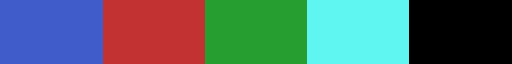

In [11]:
cm